In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
#contain many datasets like Mnist,also contains transformation of images for
#pre process datas
from torchvision import datasets, transforms

In [2]:
#we will use our GPU power for faster calculations
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
#normalization part:here we make our data to be between 1 and -1
#images are 28*28=784 pixels range 0 to 255
#transform it from an array to Tensor.
#compose make a chain of transforms
#transforms.ToTensor() make tensor float num range 0 to 1
#now we normalize this as first mean (0.5,0.5,0.5) and second one standard deviation of (ch,h,w)
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
#initialize MNIST dataset
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
#training loader which we use for batches
#shuffle will change  subset of trainig data change every iteration and save us from local minima
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

In [4]:
training_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [5]:
#for plotting we have to convert image from tensor back to numpy arr
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() #first dim chanel second w third h
    #its single color channel because its b and W so its 1*28*28
    #channel=1 and w=28 and h=28
    image = image.transpose(1, 2, 0) #we make it 28*28*1
    #denormalizing part:
    #subtracting the mean and devide by standard deviation
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    #change range back to 0 to 1
    image = image.clip(0, 1)
    return image


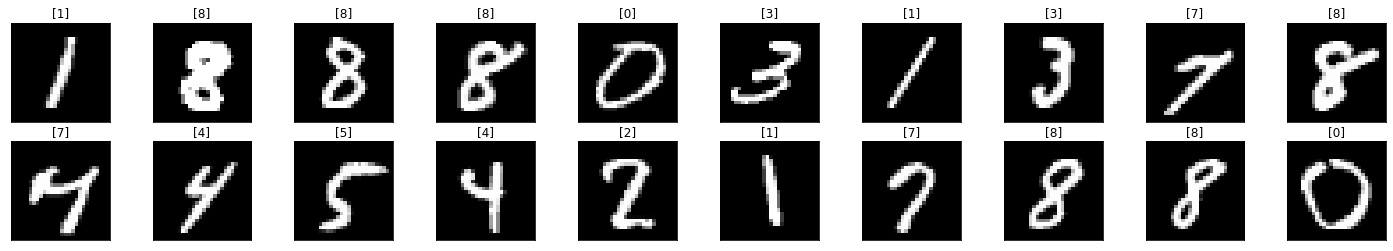

In [6]:
#loading image
#training loader which we use for batches
#iter will create an object that alows us to go iterable training_loader one elemnt at a time
#below ia a visualization of our training data
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

In [7]:
#here we use LeNet architecture :2 conv layers,2 pooling layers,2 fully connected layers
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        #first conv2d inputs are as follow:
           #first arg is num of input channels
           #second is num of output channels
           #third is filter size(n-->n*n)
           #fourth is stride size
        #here our image is black and white so we have 1 channel
        #then as we use 20 filter of the size of 5*5
        #so the formule for next layer dims is as follow:
           #with no padding -->n-f+1
           #with padding-->n+2p-f+1
        #next layer size=28-5+1=24
        #after pooling the sizes will be 12*12
        self.conv1=nn.Conv2d(1,20,5,1)
        #as the output of last layer channel was 20 here its the input channel
        #we then use 50 filters and their size is as before
        #Conv 2 dims are:12-5+1=8*8
        #after poolin2=4*4
        #so input of fc1 will be 4*4*50 as the num of channels are 50
        #notice that num of channels increase and the sizes decrease as we moving forward
        self.conv2=nn.Conv2d(20,50,5,1)
        #then we connect this to 500 nodes
        self.fc1=nn.Linear(4*4*50,500)
        #dropout
        self.dropout1=nn.Dropout(0.5)#only parameter here is prob of a node being droped out.
        #it's recommanded to use 0.5
        #after that we connect those to 10 output nodes as we will have 10 output classes
        self.fc2=nn.Linear(500,10)
        
        #this model without drop out works well but after running it it has overfitting problem
        #for solving this problem we will use dropouts
        #we can use dropouts both at conv layers and fc layers
        #but its better to use them in fc layes as the have more parameters
        
        
    def forward(self, x):
        #input-->conv1-->pool1-->conv2-->pool2-->fc1-->fc2
        x=F.relu(self.conv1(x))
        x=F.max_pool2d(x,2,2)#2*2 polling size
        x=F.relu(self.conv2(x))
        x=F.max_pool2d(x,2,2)
        x=x.view(-1,4*4*50)#flattening data before feeding it to fc layers
        x=F.relu(self.fc1(x))
        x=self.dropout1(x)
        x=self.fc2(x)#last outputs doesn't have activation function as here we will use CrossEntropyLoss
        return x

In [8]:
model = LeNet().to(device)#cuda part
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [9]:
#we use this for multiclass classification
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [10]:
#note that every batch is 1000 here
epochs = 15
running_loss_history = []
running_corrects_history = []#accuracy
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
  
  
  
    for inputs, labels in training_loader:
        #reshape and flattening image
        ###########cuda part###########
        inputs=inputs.to(device)
        labels=labels.to(device)
        ###########cuda part###########
        #no need of flattening input as we use convolutin here so we comment line below
        #inputs = inputs.view(inputs.shape[0], -1)#slice 784
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)#max score is the class we use it in running_corrects
        #runing loss is accumulated for every batch
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)#if the predict is true
        
    else:
        with torch.no_grad():#because we will not use gradients in val part
            for val_inputs, val_labels in validation_loader:
                #no need of flattening input as we use convolutin here so we comment line below
                #val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                ###########cuda part###########
                val_inputs=val_inputs.to(device)
                val_labels=val_labels.to(device)
                ###########cuda part###########
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
        
        #len(training_loader) is num of batches
        epoch_loss = running_loss/len(training_loader)
        epoch_acc = running_corrects.float()/ len(training_loader)#it gives us avg accuracy at that epoch
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch :', (e+1))#e stars at zero we want at 1
        
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
        
    
      
       
   

       
    

epoch : 1
training loss: 0.5711, acc 84.5750 
validation loss: 0.1777, validation acc 94.7900 
epoch : 2
training loss: 0.1499, acc 95.5933 
validation loss: 0.1049, validation acc 96.9500 
epoch : 3
training loss: 0.1027, acc 96.9900 
validation loss: 0.0784, validation acc 97.4200 
epoch : 4
training loss: 0.0815, acc 97.5333 
validation loss: 0.0653, validation acc 98.0000 
epoch : 5
training loss: 0.0676, acc 98.0283 
validation loss: 0.0570, validation acc 98.1900 
epoch : 6
training loss: 0.0598, acc 98.2200 
validation loss: 0.0539, validation acc 98.3300 
epoch : 7
training loss: 0.0514, acc 98.4200 
validation loss: 0.0436, validation acc 98.6500 
epoch : 8
training loss: 0.0458, acc 98.5917 
validation loss: 0.0404, validation acc 98.6500 
epoch : 9
training loss: 0.0419, acc 98.6850 
validation loss: 0.0382, validation acc 98.7000 
epoch : 10
training loss: 0.0381, acc 98.8600 
validation loss: 0.0361, validation acc 98.7600 
epoch : 11
training loss: 0.0346, acc 98.9417 
va

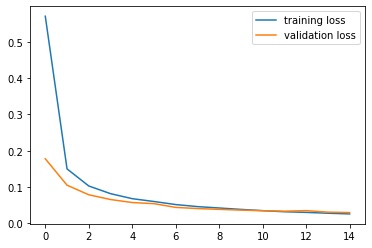

In [11]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

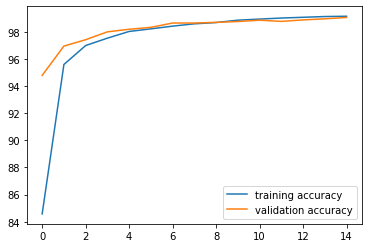

In [12]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [15]:
import PIL.ImageOps

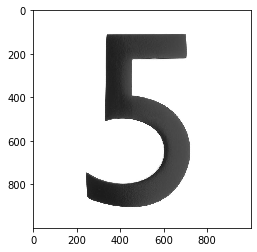

In [16]:
import requests
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

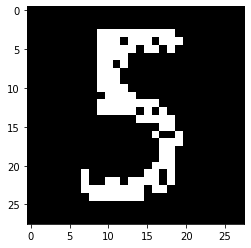

In [17]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(im_convert(img))

In [18]:
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())

5


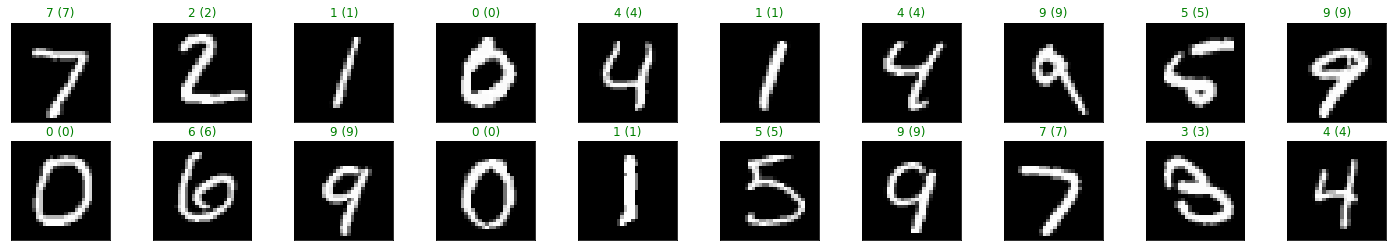

In [19]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))

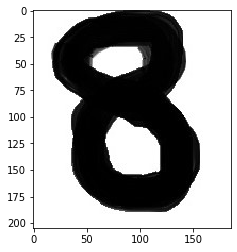

In [20]:
url = 'http://uupload.ir/files/6jp1_8.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

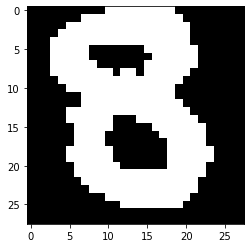

In [21]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(im_convert(img))

In [22]:
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())

8


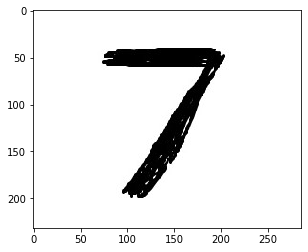

In [23]:
url = 'http://uupload.ir/files/ww1a_seven.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

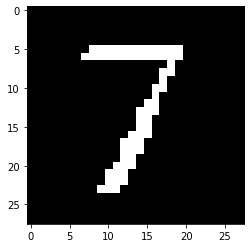

In [24]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(im_convert(img))

In [25]:
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())

7
